# Hierarchical Attentional Hybrid Neural Networks for Document Classification

Document classification is a challenging task with important applications. Deep learning approaches to the problem have gained much attention. Despite the progress, the proposed models do not incorporate the knowledge of the document structure in the architecture efficiently and not take into account the contexting dependent importance of words and sentences. In this paper, we propose a new approach based on convolutional neural networks, gated recurrent units and attention mechanisms for document classification tasks. The datasets IMDB Movie Reviews and Yelp were used in experiments. The proposed method improves the results of current attention-based approaches

Please, cite:

Abreu, J., Fred, L., Macêdo, D., & Zanchettin, C. (2019). Hierarchical Attentional Hybrid Neural Networks for Document Classification. arXiv preprint arXiv:1901.06610.

# Prompts for kaggle username and API key

Displays a field in prompt and waits for the user to input your kaggle username. By press ENTER, other field prompts for input Kaggle API key.

In [1]:
# import os
# from getpass import getpass

# user = getpass('Kaggle Username: ')
# key = getpass('Kaggle API key: ')

# if '.kaggle' not in os.listdir('/root'):
#     !mkdir ~/.kaggle
    
# !touch /root/.kaggle/kaggle.json
# !chmod 666 /root/.kaggle/kaggle.json

# with open('/root/.kaggle/kaggle.json', 'w') as f:
#     f.write('{"username":"%s","key":"%s"}' % (user, key))
# !chmod 600 /root/.kaggle/kaggle.json

# Download dataset

In [2]:
# !kaggle datasets download -d luisfredgs/hahnn-for-document-classification
# !unzip -o hahnn-for-document-classification.zip
# # fixing in 400k reviews
# !head -n400000 yelp_reviews.json > yelp_reviews_sampling.json

In [3]:
dataset = "imdb" #@param ["yelp", "imdb"]

word_embedding_type = "from_scratch" #@param ["from_scratch", "pre_trained"]
word_vector_model = "fasttext" #@param ["fasttext"]
rnn_type = "LSTM" #@param ["LSTM", "GRU"]
learning_rate = 0.001
epochs = 8
batch_size = 64

# Imports

In [4]:
# !pip -q install gensim
# !python -m spacy download en_core_web_md
# !pip -q install paramiko

import datetime, pickle, os, codecs, re, string
import json
import random
import numpy as np
import keras
import h5py
import tensorflow
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.utils import CustomObjectScope
from keras.engine.topology import Layer
# from keras.utils.layer_utils import Layer

#
from keras.engine import InputSpec

from keras import initializers

import pandas as pd
from tqdm import tqdm

import string
from spacy.lang.en import English
import gensim, nltk, logging

from nltk.corpus import stopwords
from nltk import tokenize
from nltk.stem import SnowballStemmer

nltk.download('punkt')
nltk.download('stopwords')

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# import en_core_web_sm
import spacy

from IPython.display import HTML, display

import tensorflow as tf

from numpy.random import seed
from tensorflow import set_random_seed
os.environ['PYTHONHASHSEED'] = str(1024)
set_random_seed(1024)
seed(1024)
np.random.seed(1024)
random.seed(1024)

Using TensorFlow backend.
c:\Users\Acer\anaconda3\envs\tfold1\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Acer\anaconda3\envs\tfold1\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Acer\anaconda3\envs\tfold1\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\Acer\anaconda3\envs\tfold1\lib\site-pa

# Text preprocessing

In [5]:
def clean_str(string):
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)

    cleanr = re.compile('<.*?>')

    # string = re.sub(r'\d+', '', string)
    string = re.sub(cleanr, '', string)
    # string = re.sub("'", '', string)
    # string = re.sub(r'\W+', ' ', string)
    string = string.replace('_', '')


    return string.strip().lower()

# Use pre-trained word embeddings

In [6]:
def load_subword_embedding_300d(word_index):
    print('load_subword_embedding...')
    embeddings_index = {}
    f = codecs.open("wiki-news-300d-1M-subword.vec", encoding='utf-8')
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('found %s word vectors' % len(embeddings_index))
    
    #embedding matrix
    print('preparing embedding matrix...')
    words_not_found = []
    
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if (embedding_vector is not None) and len(embedding_vector) > 0:
            
            embedding_matrix[i] = embedding_vector
        else:
            words_not_found.append(word)
    
    return embedding_matrix

# Plot word embedding chart

In [7]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):    
    plt.figure(figsize=(18, 18))
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.savefig(filename)

# Normalize texts

In [8]:
nlp = spacy.load('en_core_web_md')


puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', '#', '—–']


def clean_puncts(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

def remove_stopwords(text):
    text = str(text)    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    text = " ".join(text)
    
    return text


def normalize(text):
    text = text.lower().strip()
    doc = nlp(text)
    filtered_sentences = []
    for sentence in doc.sents:                    
        sentence = clean_puncts(sentence)
        sentence = clean_str(sentence)            
        #sentence = remove_stopwords(sentence)                
        filtered_sentences.append(sentence)
    return filtered_sentences

# Training word embeddings

In [9]:
def create_fasttext(embed_dim, data):
    
    filename = './fasttext_model.txt'
    
    if not os.path.isfile(filename):    
        print('create_fasttext...')
        sent_lst = []

        for doc in data['text']:
            doc = clean_str(doc)
            sentences = nltk.tokenize.sent_tokenize(doc)
            for sent in sentences:
                word_lst = [w for w in nltk.tokenize.word_tokenize(sent) if w.isalnum()]
                sent_lst.append(word_lst)


        logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

        fasttext_model = gensim.models.FastText(
            word_ngrams=1,
            sentences=sent_lst, 
            vector_size = embed_dim, 
            workers=os.cpu_count(), 
            window = 1)
        fasttext_model.save("./fasttext_model.txt")

# Load datasets

**1)** Yelp Dataset with 500k reviews

**2)** IMDb with 50k reviews

In [10]:
def load_data_yelp(path, train_ratio=1, size=400000):
    vector_dim = 200
    dim = 5
    
    with open(path) as f:
        reviews=f.read().strip().split("\n")
        
    df = pd.DataFrame([json.loads(review) for review in reviews])        

    text_tokens = []
    for row in tqdm(df['text']):    
        text_tokens.append(normalize(row))  
    
    df['text_tokens'] = text_tokens    
    del text_tokens
    
    vector_dim = 200     
    if word_embedding_type is 'from_scratch':
        create_fasttext(vector_dim, df)
        
    ###
    
    X = df['text_tokens'].values
    Y = pd.get_dummies(df['stars']).values
    
    return (X, Y)

def load_data_imdb(path, size=49000, train_ratio=1):    
    df = pd.read_csv(path, nrows=size, usecols=['text', 'sentiment'])        
    
    vector_dim = 200 
    
    if word_embedding_type is 'from_scratch':
        # Fasttext
        create_fasttext(vector_dim, df)
    
    ### 
    
    text_tokens = []
    for row in tqdm(df['text']):    
        text_tokens.append(normalize(row))  
    
    df['text_tokens'] = text_tokens
    
    del text_tokens
    ###
    
    X = df['text_tokens'].values
    Y = pd.get_dummies(df['sentiment']).values
    return (X, Y)


# Attention Layer
Check [(Bahdanau et al., 2015)](https://arxiv.org/pdf/1409.0473.pdf)

In [11]:
class Attention(Layer):
    def __init__(self, **kwargs):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = 50
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], 1)))
        self.b = K.variable(self.init((self.attention_dim, )))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(Attention, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)

        if mask is not None:
            ait *= K.cast(mask, K.floatx())
            
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# Model architecture

In [12]:
!rm -rf saved_models
!mkdir saved_models

'rm' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file saved_models already exists.


In [13]:
class HAHNetwork():
    def __init__(self):
        self.model = None
        self.MAX_SENTENCE_LENGTH = 0
        self.MAX_SENTENCE_COUNT = 0
        self.VOCABULARY_SIZE = 0
        self.word_embedding = None
        self.model = None
        self.word_attention_model = None
        self.tokenizer = None
        self.class_count = 2

    def build_model(self, n_classes=2, embedding_dim=200, embeddings_path=False):
        
        l2_reg = regularizers.l2(0.001)
        
        embedding_weights = np.random.normal(0, 1, (len(self.tokenizer.word_index) + 1, embedding_dim))
        
        if embeddings_path is not None:

            if word_embedding_type is 'from_scratch':
                # FastText
                filename = './fasttext_model.txt'                
                model =  gensim.models.FastText.load(filename)

                embeddings_index = model.wv                    
                embedding_matrix = np.zeros( ( len(self.tokenizer.word_index) + 1, embedding_dim) )
                for word, i in self.tokenizer.word_index.items():
                    try:
                        embedding_vector = embeddings_index[word]
                        if embedding_vector is not None:
                            embedding_matrix[i] = embedding_vector
                    except Exception as e:
                        #print(str(e))
                        continue


            else:                
                embedding_dim = 300
                embedding_matrix = load_subword_embedding_300d(self.tokenizer.word_index)

            embedding_weights = embedding_matrix

        sentence_in = Input(shape=(self.MAX_SENTENCE_LENGTH,), dtype='int32', name="input_1")
        
        embedding_trainable = True
        
        
        
        if word_embedding_type is 'pre_trained':
            embedding_trainable = False
        
        embedded_word_seq = Embedding(
            self.VOCABULARY_SIZE,
            embedding_dim,
            weights=[embedding_weights],
            input_length=self.MAX_SENTENCE_LENGTH,
            trainable=embedding_trainable,
            #mask_zero=True,
            mask_zero=False,
            name='word_embeddings',)(sentence_in) 
        
        
                     
        dropout = Dropout(0.2)(embedded_word_seq)
        filter_sizes = [3,4,5]
        convs = []
        for filter_size in filter_sizes:
            conv = Conv1D(filters=64, kernel_size=filter_size, padding='same', activation='relu')(dropout)
            pool = MaxPool1D(filter_size)(conv)
            convs.append(pool)
        
        concatenate = Concatenate(axis=1)(convs)
        
        if rnn_type is 'GRU':
            #word_encoder = Bidirectional(CuDNNGRU(50, return_sequences=True, dropout=0.2))(concatenate)                
            dropout = Dropout(0.1)(concatenate)
            word_encoder = Bidirectional(CuDNNGRU(50, return_sequences=True))(dropout)                
        else:
            word_encoder = Bidirectional(
                LSTM(50, return_sequences=True, dropout=0.2))(embedded_word_seq)
            
        
        dense_transform_word = Dense(
            100, 
            activation='relu', 
            name='dense_transform_word', 
            kernel_regularizer=l2_reg)(word_encoder)
        
        # word attention
        attention_weighted_sentence = Model(
            sentence_in, Attention(name="word_attention")(dense_transform_word))
        
        self.word_attention_model = attention_weighted_sentence
        
        attention_weighted_sentence.summary()

        # sentence-attention-weighted document scores
        
        texts_in = Input(shape=(self.MAX_SENTENCE_COUNT, self.MAX_SENTENCE_LENGTH), dtype='int32', name="input_2")
        
        attention_weighted_sentences = TimeDistributed(attention_weighted_sentence)(texts_in)
        
        
        if rnn_type is 'GRU':
            #sentence_encoder = Bidirectional(GRU(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.2))(attention_weighted_sentences)
            dropout = Dropout(0.1)(attention_weighted_sentences)
            sentence_encoder = Bidirectional(CuDNNGRU(50, return_sequences=True))(dropout)
        else:
            sentence_encoder = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.2))(attention_weighted_sentences)
        
        
        dense_transform_sentence = Dense(
            100, 
            activation='relu', 
            name='dense_transform_sentence',
            kernel_regularizer=l2_reg)(sentence_encoder)
        
        # sentence attention
        attention_weighted_text = Attention(name="sentence_attention")(dense_transform_sentence)
        
        
        prediction = Dense(n_classes, activation='softmax')(attention_weighted_text)
        
        model = Model(texts_in, prediction)
        model.summary()
        
        
        optimizer=Adam(lr=learning_rate, decay=0.0001)

        model.compile(
                      optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        return model


    def get_tokenizer_filename(self, saved_model_filename):
        return saved_model_filename + '.tokenizer'

    def fit_on_texts(self, texts):
        self.tokenizer = Tokenizer(filters='"()*,-/;[\]^_`{|}~');
        all_sentences = []
        max_sentence_count = 0
        max_sentence_length = 0
        for text in texts:
            sentence_count = len(text)
            if sentence_count > max_sentence_count:
                max_sentence_count = sentence_count
            for sentence in text:
                sentence_length = len(sentence)
                if sentence_length > max_sentence_length:
                    max_sentence_length = sentence_length
                all_sentences.append(sentence)


        self.MAX_SENTENCE_COUNT = min(max_sentence_count, 15)
        self.MAX_SENTENCE_LENGTH = min(max_sentence_length, 50)
        
        self.tokenizer.fit_on_texts(all_sentences)
        self.VOCABULARY_SIZE = len(self.tokenizer.word_index) + 1
        self.create_reverse_word_index()

    def create_reverse_word_index(self):
        self.reverse_word_index = {value:key for key,value in self.tokenizer.word_index.items()}

    def encode_texts(self, texts):
        encoded_texts = np.zeros((len(texts), self.MAX_SENTENCE_COUNT, self.MAX_SENTENCE_LENGTH))
        for i, text in enumerate(texts):
            encoded_text = np.array(pad_sequences(
                self.tokenizer.texts_to_sequences(text), 
                maxlen=self.MAX_SENTENCE_LENGTH))[:self.MAX_SENTENCE_COUNT]
            encoded_texts[i][-len(encoded_text):] = encoded_text
        return encoded_texts

    def save_tokenizer_on_epoch_end(self, path, epoch):
        if epoch == 0:
            tokenizer_state = {
                'tokenizer': self.tokenizer,
                'maxSentenceCount': self.MAX_SENTENCE_COUNT,
                'maxSentenceLength': self.MAX_SENTENCE_LENGTH,
                'vocabularySize': self.VOCABULARY_SIZE
            }
            pickle.dump(tokenizer_state, open(path, "wb" ) )

    def train(self, train_x, train_y,
              batch_size=16, 
              epochs=1, 
              embedding_dim=200, 
              embeddings_path=False, 
              saved_model_dir='saved_models', 
              saved_model_filename=None,):
        
        self.fit_on_texts(train_x)
        self.model = self.build_model(
            n_classes=train_y.shape[-1], 
            embedding_dim=200,
            embeddings_path=embeddings_path)
        encoded_train_x = self.encode_texts(train_x)
        callbacks = [
            ReduceLROnPlateau(),
            LambdaCallback(
                on_epoch_end=lambda epoch, logs: self.save_tokenizer_on_epoch_end(
                    os.path.join(saved_model_dir, 
                        self.get_tokenizer_filename(saved_model_filename)), epoch))
        ]

        if saved_model_filename:
            callbacks.append(
                ModelCheckpoint(
                    filepath=os.path.join(saved_model_dir, saved_model_filename),
                    monitor='val_acc',
                    save_best_only=True,
                    save_weights_only=False,
                )
            )
        history = self.model.fit(
                       x=encoded_train_x, 
                       y=train_y, 
                       batch_size=batch_size, 
                       epochs=epochs, 
                       verbose=1, 
                       callbacks=callbacks,
                       validation_split=0.1,  
                       shuffle=True)
        
        # Plot
        print(history.history.keys())
        
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def encode_input(self, x, log=False):
        x = np.array(x)
        if not x.shape:
            x = np.expand_dims(x, 0)
        texts = np.array([normalize(text) for text in x])
        return self.encode_texts(texts)


# Load dataset

This might take several minutes, depending your dataset

In [14]:
YELP_DATA_PATH = 'yelp_reviews_sampling.json'
IMDB_DATA_PATH = 'imdb_reviews.csv'
SAVED_MODEL_DIR = 'saved_models'
SAVED_MODEL_FILENAME = 'model.h5'

if dataset is 'yelp':
    (X, Y) = load_data_yelp(path=YELP_DATA_PATH, size=400000)
else:
    (X, Y) = load_data_imdb(path=IMDB_DATA_PATH, size=49000)


100%|██████████| 49000/49000 [48:38<00:00, 16.79it/s]  


# Plots Word Embedding chart


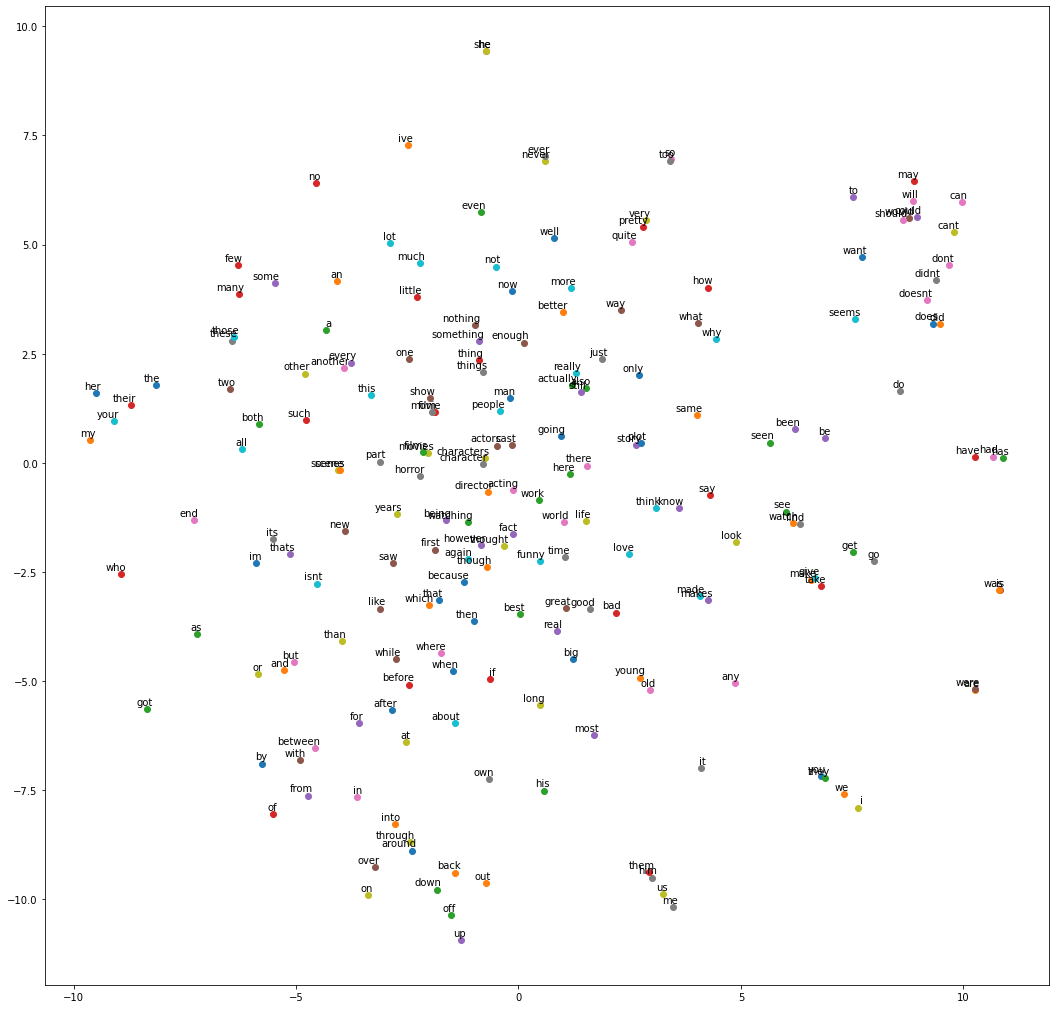

In [15]:
limit = 200
vector_dim = 200

# Fasttext
filename = './fasttext_model.txt'                
model =  gensim.models.FastText.load(filename)
words = []
embedding = np.array([])
i = 0
for word in model.wv.key_to_index.keys():
    if i == limit: break

    words.append(word)
    embedding = np.append(embedding, model.wv.get_vector(word))
    i += 1

embedding = embedding.reshape(limit, vector_dim)    
tsne = TSNE(n_components=2)
low_dim_embedding = tsne.fit_transform(embedding)
       
plot_with_labels(low_dim_embedding, words)


# Training model

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
word_embeddings (Embedding)  (None, 50, 200)           22420600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 200)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 100)           100400    
_________________________________________________________________
dense_transform_word (Dense) (None, 50, 100)           10100     
_________________________________________________________________
word_attention (Attention)   (None, 100)               200       
Total params: 22,531,300.0
Trainable params: 22,531,300.0
Non-trainab

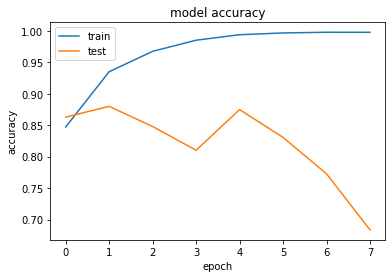

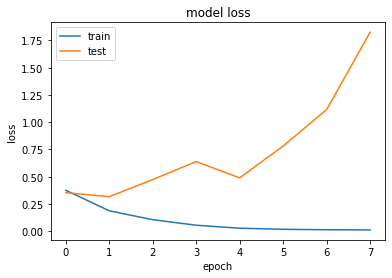

In [16]:
K.clear_session()
K.set_learning_phase(False)
model = HAHNetwork()
model.train(X, Y, batch_size=64, epochs=8, embeddings_path=True, saved_model_dir=SAVED_MODEL_DIR, saved_model_filename=SAVED_MODEL_FILENAME)